# Video Embedding, Clustering, and Semantic Search

This notebook demonstrates how to generate CLIP embeddings for videos, cluster them efficiently, and perform semantic search using the same infrastructure as images.

The approach aligns with the requirements in `docs/technical_specification.md`:
- Extract representative frames (keyframes) per video
- Encode frames with the same CLIP model (`clip-ViT-B-32`)
- Aggregate frame embeddings for a single video embedding (mean pooling)
- Cluster videos using cosine similarity (Agglomerative)
- Support text-to-video semantic search with normalized embeddings

Once implemented, both images and videos reside in the same 512-dimensional CLIP space, enabling a unified interface for media search and clustering.


In [15]:
%pip install --quiet sentence-transformers pillow matplotlib scikit-learn numpy opencv-python-headless python-dotenv requests


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [16]:
import collections
import io
import itertools
import json
import math
import os
import time
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, Iterable, List, Sequence, Tuple

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from sentence_transformers import SentenceTransformer
from sklearn.cluster import AgglomerativeClustering


In [17]:
DEVICE = "cpu"
MAX_FRAMES_PER_VIDEO = 24
MIN_SECONDS_BETWEEN_FRAMES = 0.4
FRAME_RESIZE = (224, 224)  # CLIP default crop size
FRAME_DIVERSITY_THRESHOLD = 0.15  # Minimum histogram distance between frames
VIDEO_EXTENSIONS = {".mp4", ".mov", ".avi", ".mkv", ".webm"}
TARGET_VIDEOS_PER_CLUSTER = 4
MIN_CLUSTER_SIZE_RATIO = 0.1
CLUSTER_SIMILARITY_THRESHOLD = 0.82
FRAME_ATTENTION_TEMPERATURE = 0.08


@dataclass
class VideoSample:
    path: Path
    frames: List[Image.Image]
    embedding: torch.Tensor | None = None
    frame_weights: List[float] | None = None

    def __post_init__(self) -> None:
        if self.embedding is not None and self.embedding.ndim != 1:
            raise ValueError("Video embedding must be a 1D tensor")
        if self.frame_weights is not None and len(self.frame_weights) != len(self.frames):
            raise ValueError("Frame weights must align with extracted frames")


In [18]:
def resolve_video_root() -> Path:
    """Resolve the directory containing demo videos.

    Order of preference:
    1. ./videos (relative to repo root)
    2. ./notebooks/videos
    3. ../notebooks/videos (when running from notebooks/)
    """
    cwd = Path(os.getcwd()).resolve()
    candidates = [
        cwd / "videos",
        cwd / "notebooks" / "videos",
        cwd.parent / "notebooks" / "videos",
    ]
    for candidate in candidates:
        if candidate.exists() and candidate.is_dir():
            return candidate
    raise FileNotFoundError(
        "No video directory found. Expected one of: ./videos, ./notebooks/videos."
    )


def compute_frame_histogram(frame: np.ndarray) -> np.ndarray:
    """Compute a normalized HSV histogram to measure frame diversity."""
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1], None, [32, 32], [0, 180, 0, 256])
    cv2.normalize(hist, hist, alpha=1.0, beta=0.0, norm_type=cv2.NORM_L1)
    return hist.flatten().astype("float32")


def extract_frames_from_video(
    video_path: Path,
    max_frames: int = MAX_FRAMES_PER_VIDEO,
    min_seconds_between: float = MIN_SECONDS_BETWEEN_FRAMES,
) -> List[Image.Image]:
    """Extract representative frames with temporal spacing and diversity filtering.

    Args:
        video_path: Absolute path to the video file.
        max_frames: Maximum frames to extract.
        min_seconds_between: Minimum temporal spacing (seconds) between frames.

    Returns:
        List of PIL Images resized for CLIP processing.
    """
    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        print(f"⚠️ Unable to open video: {video_path}")
        return []

    fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames <= 0:
        total_frames = int(cap.get(cv2.CAP_PROP_POS_FRAMES))
    if total_frames <= 0:
        total_frames = int(cap.get(cv2.CAP_PROP_POS_AVI_RATIO))

    if total_frames <= 0:
        print(f"⚠️ Unable to determine frame count for: {video_path}")
        cap.release()
        return []

    frame_interval = max(int(fps * min_seconds_between), 1)
    requested = min(max_frames * 3, total_frames)
    candidate_indices = np.linspace(0, total_frames - 1, num=requested, dtype=int)

    def accept_frame(raw_frame: np.ndarray, hist: np.ndarray, store: bool = True) -> Image.Image:
        frame_rgb = cv2.cvtColor(raw_frame, cv2.COLOR_BGR2RGB)
        pil_image = Image.fromarray(frame_rgb)
        pil_image = pil_image.resize(FRAME_RESIZE, Image.Resampling.BICUBIC)
        if store:
            frames.append(pil_image)
            histograms.append(hist)
        return pil_image

    frames: List[Image.Image] = []
    histograms: List[np.ndarray] = []
    last_frame_idx = -frame_interval

    for frame_idx in candidate_indices:
        if frame_idx - last_frame_idx < frame_interval:
            continue
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(frame_idx))
        success, frame = cap.read()
        if not success:
            continue
        hist = compute_frame_histogram(frame)
        if not histograms:
            accept_frame(frame, hist)
            last_frame_idx = frame_idx
            continue
        diversity = min(
            cv2.compareHist(hist, existing_hist, cv2.HISTCMP_BHATTACHARYYA)
            for existing_hist in histograms
        )
        if diversity >= FRAME_DIVERSITY_THRESHOLD or len(frames) < 3:
            accept_frame(frame, hist)
            last_frame_idx = frame_idx
        if len(frames) >= max_frames:
            break

    if not frames:
        cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
        success, frame = cap.read()
        if success:
            hist = compute_frame_histogram(frame)
            accept_frame(frame, hist)

    cap.release()
    return frames


def load_video_samples(video_root: Path) -> List[VideoSample]:
    """Load videos and extract frames for embedding."""
    samples: List[VideoSample] = []
    for path in sorted(video_root.rglob("*")):
        if path.suffix.lower() not in VIDEO_EXTENSIONS:
            continue
        frames = extract_frames_from_video(path)
        if not frames:
            continue
        samples.append(VideoSample(path=path, frames=frames))
    return samples


In [19]:
try:
    VIDEO_ROOT = resolve_video_root()
    video_samples = load_video_samples(VIDEO_ROOT)
    total_frames = sum(len(sample.frames) for sample in video_samples)
    print(f"✓ Loaded {len(video_samples)} videos from {VIDEO_ROOT}")
    print(f"  Extracted {total_frames} frames (avg {total_frames / max(len(video_samples), 1):.1f} per video)")
except FileNotFoundError as error:
    VIDEO_ROOT = None
    video_samples = []
    print(error)

if not video_samples:
    raise RuntimeError(
        "No videos available for embedding. Add sample videos to ./videos or ./notebooks/videos."
    )


[h264 @ 0x31b829f90] missing picture in access unit with size 5
[h264 @ 0x31b12e150] missing picture in access unit with size 5
[h264 @ 0x31b824450] missing picture in access unit with size 5
[h264 @ 0x31b829f90] missing picture in access unit with size 5


✓ Loaded 5 videos from /Users/aban/drive/Projects/Automated-File-Allocator/notebooks/videos
  Extracted 62 frames (avg 12.4 per video)


[h264 @ 0x31b824450] missing picture in access unit with size 5


In [20]:
model = SentenceTransformer("clip-ViT-B-32", device=DEVICE)
model.eval()
print("✓ CLIP model ready (clip-ViT-B-32)")


✓ CLIP model ready (clip-ViT-B-32)


In [21]:
def compute_video_embedding(
    sample: VideoSample,
    clip_model: SentenceTransformer,
    device: str = DEVICE,
) -> torch.Tensor:
    """Encode a video's frames and return a normalized embedding."""
    frame_embeddings = clip_model.encode(
        sample.frames,
        batch_size=min(len(sample.frames), 8),
        convert_to_tensor=True,
        device=device,
        normalize_embeddings=True,
    )
    if frame_embeddings.ndim == 1:
        frame_embeddings = frame_embeddings.unsqueeze(0)

    mean_embedding = frame_embeddings.mean(dim=0)
    temperature = max(FRAME_ATTENTION_TEMPERATURE, 1e-3)
    attention_scores = torch.matmul(frame_embeddings, mean_embedding.unsqueeze(1)).squeeze(1) / temperature
    attention_weights = torch.softmax(attention_scores, dim=0)
    weighted_embedding = torch.sum(frame_embeddings * attention_weights.unsqueeze(1), dim=0)
    combined_embedding = 0.6 * mean_embedding + 0.4 * weighted_embedding
    normalized_embedding = F.normalize(combined_embedding.unsqueeze(0), dim=1).squeeze(0)
    sample.frame_weights = attention_weights.detach().cpu().tolist()
    return normalized_embedding


def build_video_embedding_matrix(
    samples: Sequence[VideoSample],
    clip_model: SentenceTransformer,
    device: str = DEVICE,
) -> torch.Tensor:
    """Compute embeddings for a list of videos."""
    if not samples:
        raise ValueError("No video samples provided")

    embeddings: List[torch.Tensor] = []
    start_time = time.perf_counter()
    for sample in samples:
        embedding = compute_video_embedding(sample, clip_model, device)
        sample.embedding = embedding
        embeddings.append(embedding)
    duration = time.perf_counter() - start_time
    print(f"✓ Encoded {len(samples)} videos in {duration:.2f}s ({duration / len(samples):.2f}s/video)")
    return torch.stack(embeddings)


In [22]:
video_embeddings = build_video_embedding_matrix(video_samples, model, device=DEVICE)
print(f"Embedding matrix shape: {video_embeddings.shape}")


✓ Encoded 5 videos in 3.08s (0.62s/video)
Embedding matrix shape: torch.Size([5, 512])


In [23]:
def cluster_videos(
    embeddings: torch.Tensor,
    samples: Sequence[VideoSample],
    target_videos_per_cluster: int = TARGET_VIDEOS_PER_CLUSTER,
    min_cluster_ratio: float = MIN_CLUSTER_SIZE_RATIO,
    similarity_threshold: float = CLUSTER_SIMILARITY_THRESHOLD,
) -> Tuple[Dict[int, List[int]], np.ndarray]:
    """Cluster videos using cosine similarity with adaptive thresholds.

    The algorithm first attempts density-based stopping with a cosine similarity
    threshold. If that collapses everything into a single cluster, it falls back
    to a target cluster count derived from the dataset size."""
    if embeddings.size(0) != len(samples):
        raise ValueError("Embeddings count must match samples")

    num_videos = len(samples)
    if num_videos == 0:
        return {}, np.array([], dtype=np.int32)

    desired_clusters = max(1, min(num_videos, int(np.ceil(num_videos / target_videos_per_cluster))))
    min_cluster_size = max(1, int(num_videos * min_cluster_ratio))

    print(
        f"Target clusters: {desired_clusters} | Minimum cluster size: {min_cluster_size}"
    )

    embeddings_np = embeddings.cpu().numpy()
    distance_threshold = max(1.0 - similarity_threshold, 1e-3)

    clustering_start = time.perf_counter()
    try:
        agglo = AgglomerativeClustering(
            n_clusters=None,
            distance_threshold=distance_threshold,
            metric="cosine",
            linkage="average",
            compute_full_tree=True,
        )
        initial_labels = agglo.fit_predict(embeddings_np)
    except TypeError:
        agglo = AgglomerativeClustering(
            n_clusters=None,
            distance_threshold=distance_threshold,
            affinity="cosine",
            linkage="average",
            compute_full_tree=True,
        )
        initial_labels = agglo.fit_predict(embeddings_np)

    unique_labels = np.unique(initial_labels)
    if len(unique_labels) < desired_clusters and desired_clusters > 1:
        fallback = AgglomerativeClustering(
            n_clusters=desired_clusters,
            metric="cosine",
            linkage="average",
        )
        initial_labels = fallback.fit_predict(embeddings_np)
        unique_labels = np.unique(initial_labels)

    clustering_duration = time.perf_counter() - clustering_start

    clusters: Dict[int, List[int]] = collections.defaultdict(list)
    for index, label in enumerate(initial_labels):
        clusters[int(label)].append(index)

    # Merge tiny clusters into nearest centroid if needed
    if min_cluster_size > 1:
        centroids = {
            cid: F.normalize(embeddings[indices].mean(dim=0, keepdim=True), dim=1).squeeze(0)
            for cid, indices in clusters.items()
        }
        small_clusters = [cid for cid, indices in clusters.items() if len(indices) < min_cluster_size]

        for cid in small_clusters:
            if cid not in clusters:
                continue
            similarities: Dict[int, float] = {}
            for other_cid, centroid in centroids.items():
                if other_cid == cid or other_cid not in clusters:
                    continue
                similarity = torch.dot(centroids[cid], centroid).item()
                similarities[other_cid] = similarity
            if not similarities:
                continue
            best_target = max(similarities, key=similarities.get)
            clusters[best_target].extend(clusters[cid])
            merged_indices = clusters[best_target]
            centroids[best_target] = F.normalize(
                embeddings[merged_indices].mean(dim=0, keepdim=True),
                dim=1,
            ).squeeze(0)
            del clusters[cid]
            centroids.pop(cid, None)

    reindexed_clusters: Dict[int, List[int]] = collections.defaultdict(list)
    cluster_assignments = np.full(num_videos, -1, dtype=np.int32)
    for new_id, (cid, indices) in enumerate(sorted(clusters.items())):
        for idx in indices:
            reindexed_clusters[new_id].append(idx)
            cluster_assignments[idx] = new_id

    print(
        f"✓ Clustered {num_videos} videos into {len(reindexed_clusters)} clusters ({clustering_duration:.2f}s)"
    )
    sizes = [len(idxs) for idxs in reindexed_clusters.values()]
    if sizes:
        print(
            f"  Cluster size summary (min={min(sizes)}, median={int(np.median(sizes))}, max={max(sizes)})"
        )
    return reindexed_clusters, cluster_assignments


In [24]:
def select_representative_frames(
    sample: VideoSample,
    max_frames: int = 3,
) -> List[Image.Image]:
    """Return the most informative frames for a sample based on attention weights."""
    if not sample.frames:
        return []
    weights = sample.frame_weights or [1.0 / len(sample.frames)] * len(sample.frames)
    ranked = sorted(range(len(sample.frames)), key=lambda idx: weights[idx], reverse=True)
    selected = ranked[:max_frames]
    return [sample.frames[idx] for idx in selected]


def label_video_cluster_with_vlm(
    cluster_id: int,
    cluster_indices: Sequence[int],
    samples: Sequence[VideoSample],
    gemini_model,
    max_videos: int = 4,
    frames_per_video: int = 3,
) -> Dict[str, object]:
    """Label a video cluster using Gemini VLM, returning structured metadata."""
    if gemini_model is None:
        return {
            "cluster_name": f"Cluster {cluster_id}",
            "description": "",
            "tags": [],
            "primary_category": "unknown",
            "vlm_model": "fallback",
        }

    representative_indices = cluster_indices[:max_videos]
    image_parts = []
    for video_idx in representative_indices:
        sample = samples[video_idx]
        for frame in select_representative_frames(sample, max_frames=frames_per_video):
            buffer = io.BytesIO()
            frame.save(buffer, format="JPEG", quality=90)
            buffer.seek(0)
            image_parts.append({"mime_type": "image/jpeg", "data": buffer.getvalue()})

    prompt = f"""
You are analyzing a cluster of {len(cluster_indices)} related videos. Each video is represented by multiple key frames.
Describe the shared theme across all videos and provide structured metadata.

Return ONLY valid JSON with the following schema:
{{
    "cluster_name": "string",
    "description": "string",
    "tags": ["tag1", "tag2", ...],
    "primary_category": "string"
}}
"""

    try:
        response = gemini_model.generate_content(
            [prompt] + image_parts,
            generation_config={
                "response_mime_type": "application/json",
                "temperature": 0.25,
            },
        )
        payload = getattr(response, "text", None)
        if payload is None and getattr(response, "candidates", None):
            payload = response.candidates[0].content.parts[0].text
        metadata = json.loads(payload) if payload else {}
        return {
            "cluster_name": metadata.get("cluster_name", f"Cluster {cluster_id}"),
            "description": metadata.get("description", ""),
            "tags": metadata.get("tags", []),
            "primary_category": metadata.get("primary_category", "unknown"),
            "vlm_model": "gemini-2.5-flash",
            "videos_in_cluster": len(cluster_indices),
            "frames_sent": len(image_parts),
        }
    except Exception as exc:  # noqa: BLE001
        print(f"VLM labeling failed for cluster {cluster_id}: {exc}")
        return {
            "cluster_name": f"Cluster {cluster_id}",
            "description": "",
            "tags": [],
            "primary_category": "unknown",
            "vlm_model": "error-fallback",
        }


def label_all_video_clusters(
    clusters: Dict[int, List[int]],
    samples: Sequence[VideoSample],
    gemini_model,
) -> Dict[int, Dict[str, object]]:
    """Label every cluster with Gemini (if available)."""
    labels: Dict[int, Dict[str, object]] = {}
    for cluster_id, indices in clusters.items():
        labels[cluster_id] = label_video_cluster_with_vlm(
            cluster_id,
            indices,
            samples,
            gemini_model,
        )
    return labels


In [25]:
try:
    import google.generativeai as genai

    GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")
    if GEMINI_API_KEY:
        genai.configure(api_key=GEMINI_API_KEY)
        gemini_model = genai.GenerativeModel("gemini-2.5-flash")
        VLM_AVAILABLE = True
        print("✓ Gemini VLM ready")
    else:
        gemini_model = None
        VLM_AVAILABLE = False
        print("⚠ GEMINI_API_KEY not set - using fallback labels")
except ImportError:
    gemini_model = None
    VLM_AVAILABLE = False
    print("⚠ google-generativeai not installed - using fallback labels")


✓ Gemini VLM ready


In [26]:
video_clusters, video_cluster_assignments = cluster_videos(video_embeddings, video_samples)
NUM_CLUSTERS = len(video_clusters)
print(f"Assignments shape: {video_cluster_assignments.shape}")

cluster_labels = label_all_video_clusters(video_clusters, video_samples, gemini_model)
if cluster_labels:
    print("\nCluster labels:")
    for cluster_id, info in sorted(cluster_labels.items()):
        tags = ", ".join(info.get("tags", [])) or "(no tags)"
        print(f"  Cluster {cluster_id}: {info.get('cluster_name', f'Cluster {cluster_id}')} | Tags: {tags}")


Target clusters: 2 | Minimum cluster size: 1
✓ Clustered 5 videos into 4 clusters (0.01s)
  Cluster size summary (min=1, median=1, max=2)
Assignments shape: (5,)

Cluster labels:
  Cluster 0: Butterfly on Tropical Flower | Tags: butterfly, flower, nature, insect, pollination, wildlife, tropical, garden, macro, animal, ecology
  Cluster 1: Fresh Seafood Market Stall | Tags: Seafood, Market, Japan, Food, Shellfish, Crab, Scallops, Fresh Produce, Street Food, Culinary, Japanese Market, Fish Market, Vendor
  Cluster 2: Giraffes in the Wild | Tags: giraffe, wildlife, safari, africa, savanna, animals, nature, mammals, wild
  Cluster 3: Elephant Herd Crossing River | Tags: elephants, wildlife, nature, river, water, safari, herd, animal family, crossing, Africa, mammals


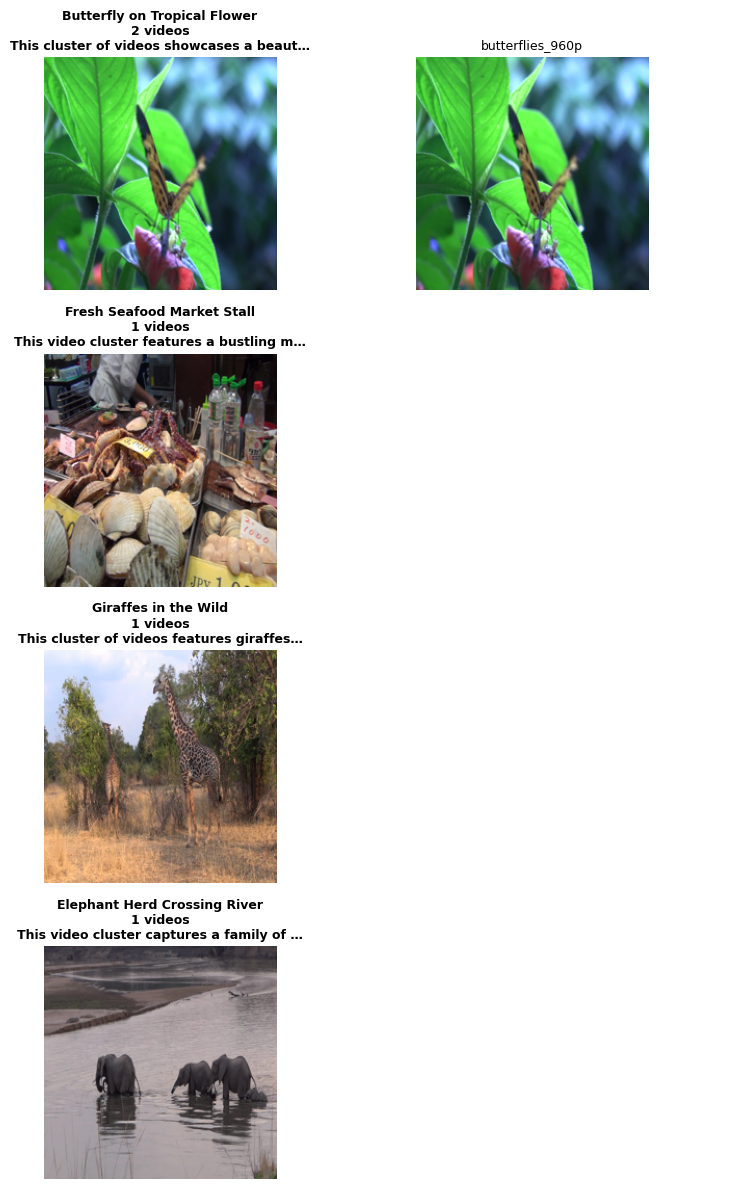

In [27]:
def show_video_cluster_grid(
    clusters: Dict[int, List[int]],
    samples: Sequence[VideoSample],
    labels: Dict[int, Dict[str, object]] | None = None,
    max_videos_per_cluster: int = 6,
) -> None:
    """Visualize clusters using the most representative frame per video."""
    if not clusters:
        print("No clusters to visualize")
        return

    rows = len(clusters)
    cols = max(1, min(max_videos_per_cluster, max(len(idxs) for idxs in clusters.values())))
    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3 * rows))
    if rows == 1:
        axes = np.expand_dims(axes, axis=0)
    if cols == 1:
        axes = np.expand_dims(axes, axis=1)

    for row, (cluster_id, indices) in enumerate(sorted(clusters.items())):
        cluster_label = labels.get(cluster_id, {}) if labels else {}
        cluster_name = cluster_label.get("cluster_name", f"Cluster {cluster_id}")
        cluster_desc = cluster_label.get("description", "")
        for col in range(cols):
            ax = axes[row][col]
            ax.axis("off")
            if col >= len(indices):
                continue
            sample = samples[indices[col]]
            reps = select_representative_frames(sample, max_frames=1)
            frame = reps[0] if reps else sample.frames[0]
            ax.imshow(frame)
            title_lines = [cluster_name if col == 0 else sample.path.stem]
            if col == 0:
                title_lines.append(f"{len(indices)} videos")
                if cluster_desc:
                    title_lines.append(cluster_desc[:40] + ("…" if len(cluster_desc) > 40 else ""))
            ax.set_title("\n".join(title_lines), fontsize=9, fontweight="bold" if col == 0 else "normal")
    plt.tight_layout()
    plt.show()


# Cluster visualization (labels provided after VLM step)
show_video_cluster_grid(video_clusters, video_samples, labels=cluster_labels)



In [28]:
def semantic_search_videos(
    query: str,
    clip_model: SentenceTransformer,
    video_embeddings: torch.Tensor,
    samples: Sequence[VideoSample],
    top_k: int = 10,
    device: str = DEVICE,
) -> List[Tuple[VideoSample, float]]:
    """Return videos most similar to the text query using cosine similarity."""
    if not query.strip():
        raise ValueError("Query must be non-empty")

    query_embedding = clip_model.encode(
        query,
        convert_to_tensor=True,
        device=device,
        normalize_embeddings=True,
    )
    similarities = torch.matmul(query_embedding, video_embeddings.T).squeeze(0)
    top_indices = torch.topk(similarities, k=min(top_k, len(samples))).indices.cpu().tolist()
    return [(samples[idx], similarities[idx].item()) for idx in top_indices]


def display_video_search_results(
    query: str,
    results: Sequence[Tuple[VideoSample, float]],
    max_display: int = 12,
) -> None:
    """Visualize semantic search results for videos."""
    if not results:
        print(f"No results for query: '{query}'")
        return

    display_count = min(len(results), max_display)
    cols = 4
    rows = math.ceil(display_count / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3 * rows))
    if rows == 1:
        axes = np.expand_dims(axes, axis=0)
    if cols == 1:
        axes = np.expand_dims(axes, axis=1)

    fig.suptitle(f"Semantic Search Results: '{query}'", fontsize=16, fontweight="bold")

    for idx in range(display_count):
        row = idx // cols
        col = idx % cols
        ax = axes[row][col]
        ax.axis("off")
        sample, score = results[idx]
        ax.imshow(sample.frames[0])
        ax.set_title(
            f"Score: {score:.3f}\n{sample.path.name}",
            fontsize=9,
        )

    # Hide unused axes
    for idx in range(display_count, rows * cols):
        row = idx // cols
        col = idx % cols
        axes[row][col].axis("off")

    plt.tight_layout()
    plt.show()

    print(f"\nTop {display_count} results for '{query}':")
    for rank, (sample, score) in enumerate(results[:display_count], start=1):
        print(f"  {rank}. {sample.path.name} (similarity {score:.4f})")


def search_videos(query: str, top_k: int = 12) -> List[Tuple[VideoSample, float]]:
    """Convenience wrapper to run semantic video search and display results."""
    results = semantic_search_videos(
        query=query,
        clip_model=model,
        video_embeddings=video_embeddings,
        samples=video_samples,
        top_k=top_k,
        device=DEVICE,
    )
    display_video_search_results(query, results, max_display=top_k)
    return results


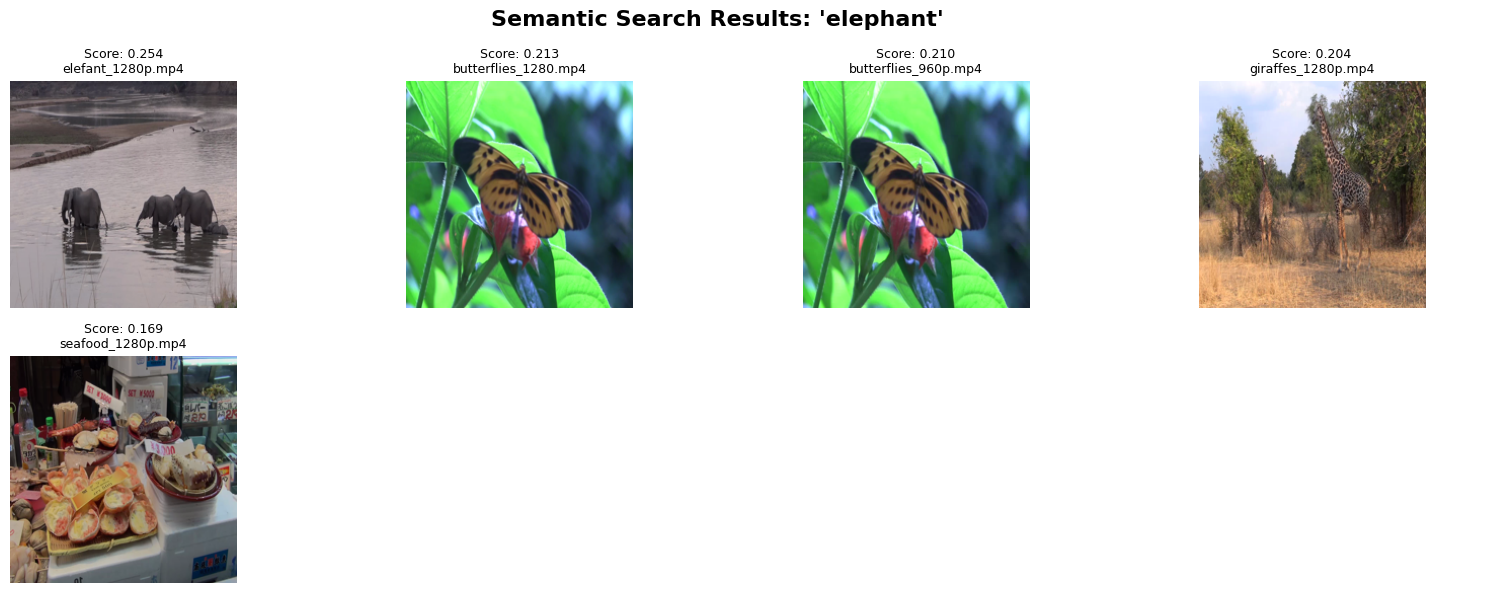


Top 5 results for 'elephant':
  1. elefant_1280p.mp4 (similarity 0.2538)
  2. butterflies_1280.mp4 (similarity 0.2129)
  3. butterflies_960p.mp4 (similarity 0.2103)
  4. giraffes_1280p.mp4 (similarity 0.2043)
  5. seafood_1280p.mp4 (similarity 0.1694)


In [29]:
# Example semantic search
# Adjust the query to match your dataset (e.g., "surfing", "city skyline", "dog")
results = search_videos("elephant", top_k=8)


## Integration Notes

- Video embeddings live in the same 512-dimensional CLIP space as image embeddings, enabling a unified pgvector-backed search index.
- Store per-video frame embeddings if you need richer temporal search (as described in `docs/technical_specification.md`). This notebook mean-pools frame vectors to produce a single video embedding for efficient clustering.
- The clustering strategy mirrors the image pipeline: cosine similarity, Agglomerative clustering, and a merge pass for tiny clusters.
- The `search_videos` helper mirrors the image search API, simplifying integration into a single FastAPI `/search` endpoint that can handle both media types based on query parameters.
- Swap in an `ffmpeg`-based frame extractor for production to match Stage 2 of the media pipeline; the OpenCV sampler here keeps the demo lightweight.
